In [1]:
from mhadatareader import MhaDataReader
from classes import ParticipantsData, Scan, ProficiencyLabel
import utils as ut
import tensorflow as tf
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import random
from tensorflow.keras.utils import plot_model
from sklearn.metrics import recall_score, confusion_matrix, plot_confusion_matrix

import os 

In [2]:
DIR_NAME = './data_bckp'
MODEL_NAME = 'best_model.tf'
LOG_DIR = './logs'

In [3]:
def save_model(model, fold):
    model.save(f'./best_model_{fold}.tf')

In [4]:
novices_all, intermed_all, experts_all = ut.load_data(DIR_NAME)
prepared = ut.prepare_data(novices_all, intermed_all, experts_all)
slice_window = 70
print(slice_window)

70


In [5]:
folds_stats = []
models_train_hist = dict()

# hyper-parameters #
kernel_size = 5
filters = 64
epochs = 300
batch_size = 32
dropout_rate = 0.5
learning_rate = 0.0001

CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=10, 
        min_lr=0.000001),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        verbose=1,
    )
]
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
)
iterations = list(it.permutations([i for i in range(len(prepared[ut.Scan.ALL]))]))
regularizer = keras.regularizers.l1_l2(0.05)

In [6]:
def build_model(input_shape, num_classes, filters, kernel_size, dropout_rate, regularizer):
    input_layer = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", 
                                kernel_regularizer=regularizer,
                                activation='relu')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(dropout_rate)(conv1)
    
    conv2 = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                padding="same", kernel_regularizer=regularizer,
                                activation='relu')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(dropout_rate)(conv2)

    conv3 = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                padding="same", kernel_regularizer=regularizer,
                                activation='relu')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(dropout_rate)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [8]:
novices_all, intermed_all, experts_all = prepared[ut.Scan.ALL]
folds_all = ut.form_folds(novices_all, intermed_all, experts_all)

for i in range(len(iterations)):
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_train, y_train = train
    x_val, y_val = valid
    x_test, y_test = test
    
    print(f'Running fold {i + 1}')
    
    model = build_model(
        x_train.shape[1:], 
        len(ProficiencyLabel), 
        kernel_size=kernel_size, 
        filters=filters, 
        dropout_rate=dropout_rate, 
        regularizer=regularizer
    )
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    plot_model(model, to_file='model.png')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=CALLBACKS,
        validation_data=(x_val, y_val),
        verbose=1,
    )
    
    models_train_hist[i] = history.history

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy', test_acc)
    print('Test loss', test_loss)
    
    
    #save_model(model, i)

    folds_stats.append((test_loss, test_acc))

Running fold 1
Epoch 1/300
668/668 [==============================] - 6s 7ms/step - loss: 80.1633 - sparse_categorical_accuracy: 0.5080 - val_loss: 2.3487 - val_sparse_categorical_accuracy: 0.4377
Epoch 2/300
546/668 [=======================>......] - ETA: 0s - loss: 1.3262 - sparse_categorical_accuracy: 0.6507

KeyboardInterrupt: 

In [11]:
mean_all = []
for i in range(6):
    mean_all.append(models_train_hist[i]['val_sparse_categorical_accuracy'][-1])
    

In [12]:
np.mean(mean_all)

0.9674232006072998

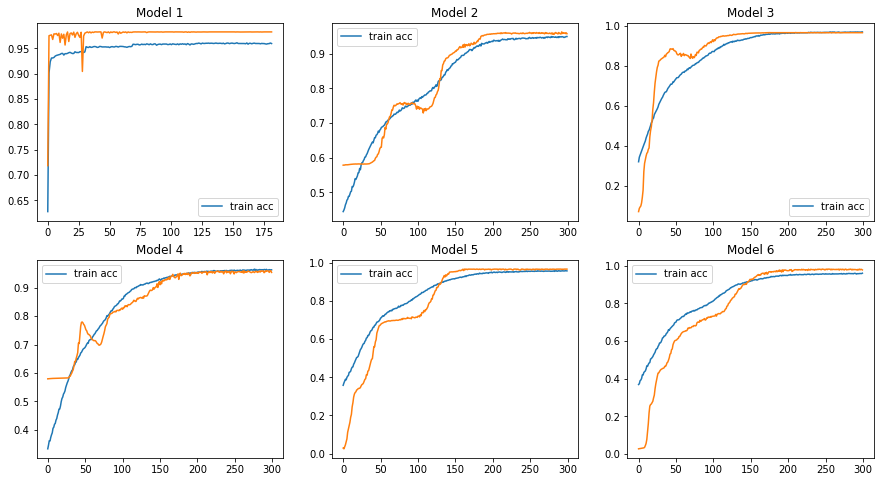

In [13]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

cnt = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[cnt]['sparse_categorical_accuracy']) 
        axs[i,j].plot(models_train_hist[cnt]['val_sparse_categorical_accuracy'])
        axs[i,j].set_title(f'Model {cnt + 1}')
        axs[i,j].legend(['train acc',], loc='best')
        cnt += 1
    
    
plt.show()
#fib.savefig('./training_acc.png', bbox_inches='tight', pad_inches=0)


model_n 1
model_n 3
model_n 5


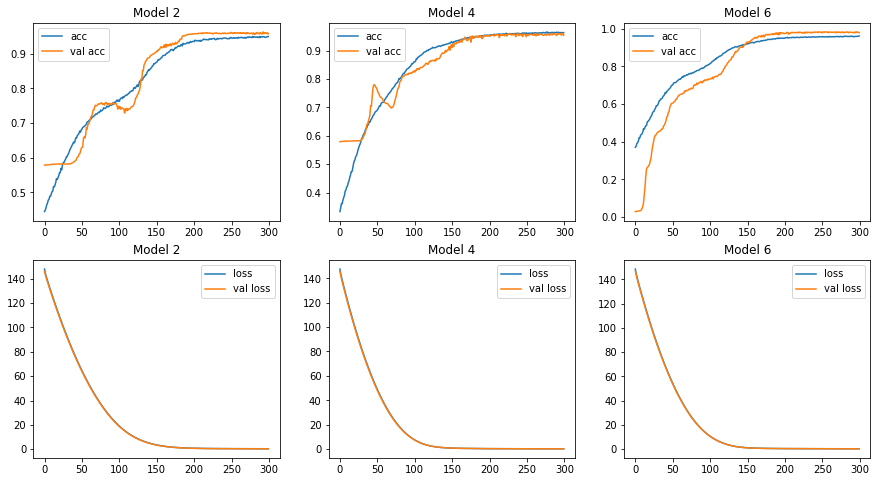

In [14]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

for j, model_n in zip(range(3), [1, 3, 5]):
    axs[0,j].plot(models_train_hist[model_n]['sparse_categorical_accuracy']) 
    axs[0,j].plot(models_train_hist[model_n]['val_sparse_categorical_accuracy'])
    axs[0,j].set_title(f'Model {model_n + 1}')
    axs[0,j].legend(['acc', 'val acc',], loc='best')
    cnt += 1

for j, model_n in zip(range(3), [1, 3, 5]):
    print(f'model_n {model_n}')
    axs[1,j].plot(models_train_hist[model_n]['loss']) 
    axs[1,j].plot(models_train_hist[model_n]['val_loss'])
    axs[1,j].set_title(f'Model {model_n + 1}')
    axs[1,j].legend(['loss', 'val loss',], loc='best')
    cnt += 1
    
plt.show()


In [206]:
folds_stats_t = folds_stats

avg_acc = 0
for i in range(len(folds_stats_t)):
    avg_acc = avg_acc + folds_stats_t[i][1]
    if i == len(folds_stats_t) - 1:
        avg_acc = avg_acc / len(folds_stats_t)

avg_loss = 0
for i in range(len(folds_stats_t)):
    avg_loss = avg_loss + folds_stats_t[i][0]
    if i == len(folds_stats_t) - 1:
        avg_loss = avg_loss / len(folds_stats_t)

print(f'AVG test acc: {avg_acc}')
print(f'AVG test loss: {avg_loss}')
print(folds_stats_t)

AVG test acc: 0.9669898847738901
AVG test loss: 0.27762331316868466
[(0.18204639852046967, 0.9755274653434753), (0.28383031487464905, 0.9710618853569031), (0.2562311887741089, 0.9753764271736145), (0.32408639788627625, 0.9524021744728088), (0.3433550298213959, 0.9590749740600586), (0.27619054913520813, 0.9684963822364807)]


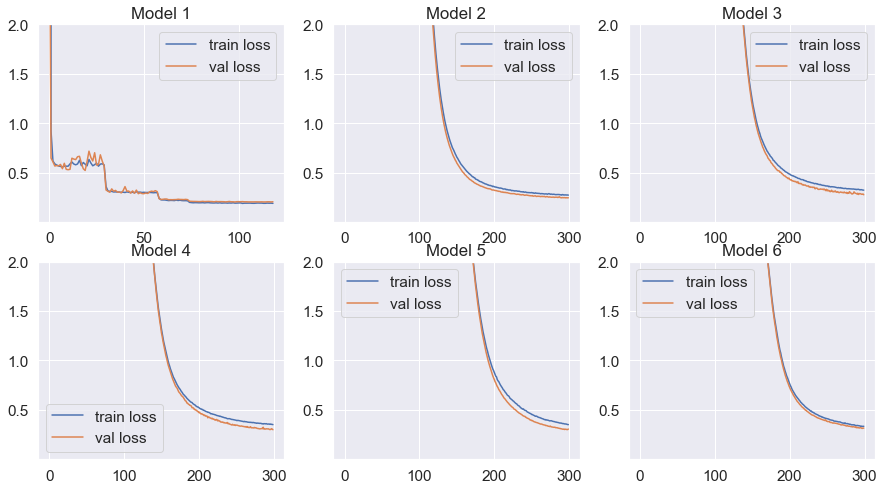

In [201]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

cnt = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[cnt]['loss']) 
        axs[i,j].plot(models_train_hist[cnt]['val_loss'])
        axs[i,j].set_title(f'Model {cnt + 1}')
        axs[i,j].set_ylim(0.0001, 2)
        axs[i,j].legend(['train loss', 'val loss',], loc='best')
        cnt += 1
    
    
plt.show()
# fib.savefig('./dist_chars.png', bbox_inches='tight', pad_inches=0)

## Finetuning

In [189]:
fine_models_train_hist = dict()
fine_folds_stats = dict()

for i in range(6):
    fine_models_train_hist[i] = dict()
    fine_folds_stats[i] = dict()
    for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
        fine_models_train_hist[i][reg] = dict()
        fine_folds_stats[i][reg] = []

In [190]:
# hyper-parameters #
fine_epochs = 100
fine_batch_size = 32
fine_kernel_size = 5
fine_filters = 64
fine_dropout_rate = 0.7
fine_learning_rate = 0.00001
fine_regularizer = keras.regularizers.l1_l2(0.07)
fine_CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001
    )
]

In [191]:
def load_model(num, reg):
    build = True
    
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    if (os.path.exists(m_name_tuned)):
        print(f'loading prev tuned {m_name_tuned}')
        return keras.models.load_model(m_name_tuned), not build

    m_name_untuned = f'./best_model_{num}.tf'
    print(f'loading non-tuned {m_name_untuned}')
    return keras.models.load_model(m_name_untuned), build


def save_model_tune(model, num, reg):
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    
    print(f'saving {m_name_tuned}')
    model.save(m_name_tuned)

def build_model_funetune(base_model, input_shape, num_classes, filters, 
                         kernel_size, dropout_rate, regularizer):
    assert base_model is not None
    model = keras.Sequential()
    
    # freeze the base model
    base_model.trainable = False
    # add all layers except the last two
    for layer in base_model.layers[:-2]: 
        model.add(layer)

    model.add(keras.layers.Conv1D(filters=filters, 
                            kernel_size=kernel_size, padding="same", 
                            kernel_regularizer=regularizer,
                            activation='relu',
                            name=f'Conv1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.BatchNormalization(
        name=f'BatchNormalization_{str(len(model.layers) + 1)}'
    ))
    model.add(keras.layers.Dropout(dropout_rate,
                                  name=f'Dropout_{str(len(model.layers) + 1)}'
                                  ))

    model.add(keras.layers.GlobalAveragePooling1D(name=f'GlobalAveragePooling1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.Dense(num_classes, activation='softmax',
                                 name=f'Dense_{str(len(model.layers) + 1)}'))
        
    model.compile(
                optimizer=keras.optimizers.Adam(
                    learning_rate=learning_rate
                ),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])
    
    return model

In [192]:
print(iterations)

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


## Region training

In [193]:
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        
        print(f'Running fold on {reg} {i + 1}')
        print(f'Loading model {i} for region {reg}')
        model, build = load_model(i, reg.name)
        if build:
            print(f'building model {reg} {i}')
            model = build_model_funetune(
                model,
                x_train.shape[1:], 
                len(ProficiencyLabel), 
                kernel_size=fine_kernel_size, 
                filters=fine_filters, 
                dropout_rate=fine_dropout_rate, 
                regularizer=fine_regularizer,
            )
        
        
        history = model.fit(
            x_train,
            y_train,
            batch_size=fine_batch_size,
            epochs=fine_epochs,
            callbacks=fine_CALLBACKS,
            validation_data=(x_val, y_val),
            verbose=1,
        )
        fine_models_train_hist[i][reg] = history.history

        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f'Test accuracy {reg}', test_acc)
        print(f'Test loss {reg}', test_loss)

        save_model_tune(model, i, reg)

        fine_folds_stats[i][reg].append((test_loss, test_acc))

Running fold on Scan.LUQ 1
Loading model 0 for region Scan.LUQ
loading non-tuned ./best_model_0.tf
building model Scan.LUQ 0
Epoch 1/100
219/219 [==============================] - 3s 8ms/step - loss: 63.9092 - sparse_categorical_accuracy: 0.5634 - val_loss: 43.3588 - val_sparse_categorical_accuracy: 0.9856
Epoch 2/100
219/219 [==============================] - 2s 9ms/step - loss: 37.6327 - sparse_categorical_accuracy: 0.8945 - val_loss: 22.2526 - val_sparse_categorical_accuracy: 0.9856
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 18.3696 - sparse_categorical_accuracy: 0.9555 - val_loss: 8.2481 - val_sparse_categorical_accuracy: 0.9856
Epoch 4/100
219/219 [==============================] - 2s 7ms/step - loss: 6.0925 - sparse_categorical_accuracy: 0.9758 - val_loss: 1.2724 - val_sparse_categorical_accuracy: 0.9856
Epoch 5/100
219/219 [==============================] - 1s 6ms/step - loss: 0.8178 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.3054 - val_s

219/219 [==============================] - 1s 5ms/step - loss: 0.2279 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.2123 - val_sparse_categorical_accuracy: 0.9856
Epoch 91/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2250 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.2017 - val_sparse_categorical_accuracy: 0.9856
Epoch 92/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.1994 - val_sparse_categorical_accuracy: 0.9856
Epoch 93/100
219/219 [==============================] - 1s 6ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.1894 - val_sparse_categorical_accuracy: 0.9856
Epoch 94/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2440 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.2076 - val_sparse_categorical_accuracy: 0.9856
Epoch 95/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2338 - sparse_categorical

Epoch 33/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2907 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.3791 - val_sparse_categorical_accuracy: 0.9530
Epoch 34/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2897 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.3817 - val_sparse_categorical_accuracy: 0.9530
Epoch 35/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.3876 - val_sparse_categorical_accuracy: 0.9530
Epoch 36/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2936 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.3736 - val_sparse_categorical_accuracy: 0.9530
Epoch 37/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2826 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.3641 - val_sparse_categorical_accuracy: 0.9530
Epoch 38/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2764 - spars

219/219 [==============================] - 1s 5ms/step - loss: 0.2353 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.9530
Epoch 79/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2440 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.3454 - val_sparse_categorical_accuracy: 0.9530
Epoch 80/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2542 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.9530
Epoch 81/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2493 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.3443 - val_sparse_categorical_accuracy: 0.9530
Epoch 82/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.9530
Epoch 83/100
219/219 [==============================] - 1s 5ms/step - loss: 0.2553 - sparse_categorical

Epoch 21/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.2797 - val_sparse_categorical_accuracy: 0.9833
Epoch 22/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.2999 - val_sparse_categorical_accuracy: 0.9833
Epoch 23/100
293/293 [==============================] - 2s 5ms/step - loss: 0.2955 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.9833
Epoch 24/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2841 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.2672 - val_sparse_categorical_accuracy: 0.9833
Epoch 25/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2849 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9833
Epoch 26/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2810 - spars

293/293 [==============================] - 1s 4ms/step - loss: 0.2635 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.9833
Epoch 67/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2727 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.2628 - val_sparse_categorical_accuracy: 0.9833
Epoch 68/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2632 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.2710 - val_sparse_categorical_accuracy: 0.9833
Epoch 69/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2771 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.2758 - val_sparse_categorical_accuracy: 0.9833
Epoch 70/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.2523 - val_sparse_categorical_accuracy: 0.9833
Epoch 71/100
293/293 [==============================] - 1s 5ms/step - loss: 0.2635 - sparse_categorical

Epoch 9/100
293/293 [==============================] - 1s 5ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.4138 - val_sparse_categorical_accuracy: 0.9530
Epoch 10/100
293/293 [==============================] - 1s 5ms/step - loss: 0.3302 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.4202 - val_sparse_categorical_accuracy: 0.9530
Epoch 11/100
293/293 [==============================] - 1s 5ms/step - loss: 0.3385 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.4261 - val_sparse_categorical_accuracy: 0.9530
Epoch 12/100
293/293 [==============================] - 1s 5ms/step - loss: 0.3252 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.9530
Epoch 13/100
293/293 [==============================] - 1s 5ms/step - loss: 0.3330 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.4079 - val_sparse_categorical_accuracy: 0.9530
Epoch 14/100
293/293 [==============================] - 1s 4ms/step - loss: 0.3179 - sparse

293/293 [==============================] - 1s 4ms/step - loss: 0.2814 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.3773 - val_sparse_categorical_accuracy: 0.9530
Epoch 55/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2793 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.3922 - val_sparse_categorical_accuracy: 0.9530
Epoch 56/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2907 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.3920 - val_sparse_categorical_accuracy: 0.9530
Epoch 57/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2864 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.3764 - val_sparse_categorical_accuracy: 0.9530
Epoch 58/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.4162 - val_sparse_categorical_accuracy: 0.9530
Epoch 59/100
293/293 [==============================] - 1s 4ms/step - loss: 0.2861 - sparse_categorical

Epoch 42/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.9833
Epoch 43/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.3177 - val_sparse_categorical_accuracy: 0.9833
Epoch 44/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4255 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9833
Epoch 45/100
198/198 [==============================] - 1s 6ms/step - loss: 0.4153 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.3160 - val_sparse_categorical_accuracy: 0.9833
Epoch 46/100
198/198 [==============================] - 1s 6ms/step - loss: 0.4253 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.3290 - val_sparse_categorical_accuracy: 0.9833
Epoch 47/100
198/198 [==============================] - 1s 6ms/step - loss: 0.4158 - spars

198/198 [==============================] - 1s 6ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.9502 - val_loss: 0.3094 - val_sparse_categorical_accuracy: 0.9833
Epoch 88/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4223 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.3032 - val_sparse_categorical_accuracy: 0.9833
Epoch 89/100
198/198 [==============================] - 1s 5ms/step - loss: 0.3980 - sparse_categorical_accuracy: 0.9511 - val_loss: 0.3292 - val_sparse_categorical_accuracy: 0.9833
Epoch 90/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.9833
Epoch 91/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4066 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.3063 - val_sparse_categorical_accuracy: 0.9833
Epoch 92/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4110 - sparse_categorical

Epoch 30/100
198/198 [==============================] - 1s 6ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.9856
Epoch 31/100
198/198 [==============================] - 1s 6ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.2928 - val_sparse_categorical_accuracy: 0.9856
Epoch 32/100
198/198 [==============================] - 1s 6ms/step - loss: 0.4199 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.3102 - val_sparse_categorical_accuracy: 0.9856
Epoch 33/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4105 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.3376 - val_sparse_categorical_accuracy: 0.9856
Epoch 34/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4285 - sparse_categorical_accuracy: 0.9434 - val_loss: 0.2903 - val_sparse_categorical_accuracy: 0.9856
Epoch 35/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4036 - spars

198/198 [==============================] - 1s 7ms/step - loss: 0.3921 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.2824 - val_sparse_categorical_accuracy: 0.9856
Epoch 76/100
198/198 [==============================] - 1s 6ms/step - loss: 0.3840 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.9856
Epoch 77/100
198/198 [==============================] - 1s 6ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.2868 - val_sparse_categorical_accuracy: 0.9856
Epoch 78/100
198/198 [==============================] - 1s 6ms/step - loss: 0.3886 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9856
Epoch 79/100
198/198 [==============================] - 1s 6ms/step - loss: 0.3972 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.2832 - val_sparse_categorical_accuracy: 0.9856
Epoch 80/100
198/198 [==============================] - 1s 5ms/step - loss: 0.3885 - sparse_categorical

Epoch 18/100
181/181 [==============================] - 1s 6ms/step - loss: 0.2641 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.2349 - val_sparse_categorical_accuracy: 0.9876
Epoch 19/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.2328 - val_sparse_categorical_accuracy: 0.9876
Epoch 20/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2670 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.2389 - val_sparse_categorical_accuracy: 0.9876
Epoch 21/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.9836 - val_loss: 0.2363 - val_sparse_categorical_accuracy: 0.9876
Epoch 22/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.2273 - val_sparse_categorical_accuracy: 0.9876
Epoch 23/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2546 - spars

181/181 [==============================] - 1s 5ms/step - loss: 0.2051 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.2057 - val_sparse_categorical_accuracy: 0.9876
Epoch 64/100
181/181 [==============================] - 1s 5ms/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.2110 - val_sparse_categorical_accuracy: 0.9876
Epoch 65/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.2124 - val_sparse_categorical_accuracy: 0.9876
Epoch 66/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2121 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.2139 - val_sparse_categorical_accuracy: 0.9876
Epoch 67/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2314 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.2009 - val_sparse_categorical_accuracy: 0.9876
Epoch 68/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1994 - sparse_categorical

Epoch 6/100
181/181 [==============================] - 1s 5ms/step - loss: 0.6097 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.3787 - val_sparse_categorical_accuracy: 0.9850
Epoch 7/100
181/181 [==============================] - 1s 5ms/step - loss: 0.3746 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.3603 - val_sparse_categorical_accuracy: 0.9850
Epoch 8/100
181/181 [==============================] - 1s 5ms/step - loss: 0.3665 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.3523 - val_sparse_categorical_accuracy: 0.9850
Epoch 9/100
181/181 [==============================] - 1s 5ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.3496 - val_sparse_categorical_accuracy: 0.9850
Epoch 10/100
181/181 [==============================] - 1s 5ms/step - loss: 0.3515 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.3487 - val_sparse_categorical_accuracy: 0.9842
Epoch 11/100
181/181 [==============================] - 1s 5ms/step - loss: 0.3179 - sparse_ca

181/181 [==============================] - 1s 5ms/step - loss: 0.2786 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9832
Epoch 52/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2674 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.9802
Epoch 53/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.2776 - val_sparse_categorical_accuracy: 0.9840
Epoch 54/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.2733 - val_sparse_categorical_accuracy: 0.9807
Epoch 55/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2599 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9850
Epoch 56/100
181/181 [==============================] - 1s 5ms/step - loss: 0.2651 - sparse_categorical

Epoch 39/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3166 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.2485 - val_sparse_categorical_accuracy: 0.9903
Epoch 40/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3102 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.2739 - val_sparse_categorical_accuracy: 0.9903
Epoch 41/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.2545 - val_sparse_categorical_accuracy: 0.9903
Epoch 42/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3263 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9903
Epoch 43/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3173 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.2477 - val_sparse_categorical_accuracy: 0.9903
Epoch 44/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3194 - spars

230/230 [==============================] - 1s 5ms/step - loss: 0.3174 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.9903
Epoch 85/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.2551 - val_sparse_categorical_accuracy: 0.9903
Epoch 86/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.2542 - val_sparse_categorical_accuracy: 0.9903
Epoch 87/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3231 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.2716 - val_sparse_categorical_accuracy: 0.9903
Epoch 88/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.2496 - val_sparse_categorical_accuracy: 0.9903
Epoch 89/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3135 - sparse_categorical

Epoch 27/100
230/230 [==============================] - 1s 6ms/step - loss: 0.3502 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.3803 - val_sparse_categorical_accuracy: 0.9311
Epoch 28/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3302 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.3491 - val_sparse_categorical_accuracy: 0.9566
Epoch 29/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3399 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.3570 - val_sparse_categorical_accuracy: 0.9556
Epoch 30/100
230/230 [==============================] - 1s 6ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.3790 - val_sparse_categorical_accuracy: 0.9320
Epoch 31/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3310 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.3481 - val_sparse_categorical_accuracy: 0.9489
Epoch 32/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3354 - spars

230/230 [==============================] - 1s 5ms/step - loss: 0.3117 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.3893 - val_sparse_categorical_accuracy: 0.9248
Epoch 73/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.3428 - val_sparse_categorical_accuracy: 0.9336
Epoch 74/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2988 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.3181 - val_sparse_categorical_accuracy: 0.9476
Epoch 75/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3053 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.3138 - val_sparse_categorical_accuracy: 0.9515
Epoch 76/100
230/230 [==============================] - 1s 5ms/step - loss: 0.2967 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.3227 - val_sparse_categorical_accuracy: 0.9503
Epoch 77/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3094 - sparse_categorical

Epoch 15/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.9282 - val_loss: 0.3674 - val_sparse_categorical_accuracy: 0.9901
Epoch 16/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4799 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.9903
Epoch 17/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4691 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.3351 - val_sparse_categorical_accuracy: 0.9903
Epoch 18/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4779 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.3548 - val_sparse_categorical_accuracy: 0.9903
Epoch 19/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4781 - sparse_categorical_accuracy: 0.9263 - val_loss: 0.3433 - val_sparse_categorical_accuracy: 0.9903
Epoch 20/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4635 - spars

244/244 [==============================] - 1s 5ms/step - loss: 0.4320 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.3066 - val_sparse_categorical_accuracy: 0.9903
Epoch 61/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4273 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.2939 - val_sparse_categorical_accuracy: 0.9903
Epoch 62/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4294 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.3037 - val_sparse_categorical_accuracy: 0.9903
Epoch 63/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4384 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.3100 - val_sparse_categorical_accuracy: 0.9903
Epoch 64/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4400 - sparse_categorical_accuracy: 0.9232 - val_loss: 0.3013 - val_sparse_categorical_accuracy: 0.9903
Epoch 65/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4247 - sparse_categorical

Epoch 3/100
244/244 [==============================] - 1s 6ms/step - loss: 14.7519 - sparse_categorical_accuracy: 0.9049 - val_loss: 5.3906 - val_sparse_categorical_accuracy: 0.9736
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 3.7141 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.6170 - val_sparse_categorical_accuracy: 0.9715
Epoch 5/100
244/244 [==============================] - 1s 6ms/step - loss: 0.6024 - sparse_categorical_accuracy: 0.9325 - val_loss: 0.3852 - val_sparse_categorical_accuracy: 0.9852
Epoch 6/100
244/244 [==============================] - 2s 7ms/step - loss: 0.5066 - sparse_categorical_accuracy: 0.9357 - val_loss: 0.3695 - val_sparse_categorical_accuracy: 0.9862
Epoch 7/100
244/244 [==============================] - 2s 8ms/step - loss: 0.5207 - sparse_categorical_accuracy: 0.9261 - val_loss: 0.3565 - val_sparse_categorical_accuracy: 0.9865
Epoch 8/100
244/244 [==============================] - 2s 7ms/step - loss: 0.4932 - sparse_cat

244/244 [==============================] - 1s 5ms/step - loss: 0.4418 - sparse_categorical_accuracy: 0.9319 - val_loss: 0.3136 - val_sparse_categorical_accuracy: 0.9837
Epoch 49/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4458 - sparse_categorical_accuracy: 0.9299 - val_loss: 0.3273 - val_sparse_categorical_accuracy: 0.9815
Epoch 50/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4288 - sparse_categorical_accuracy: 0.9362 - val_loss: 0.3122 - val_sparse_categorical_accuracy: 0.9876
Epoch 51/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4438 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.3216 - val_sparse_categorical_accuracy: 0.9800
Epoch 52/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4251 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.3290 - val_sparse_categorical_accuracy: 0.9849
Epoch 53/100
244/244 [==============================] - 1s 5ms/step - loss: 0.4578 - sparse_categorical

Epoch 36/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.1608 - val_sparse_categorical_accuracy: 0.9975
Epoch 37/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2100 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.1604 - val_sparse_categorical_accuracy: 0.9975
Epoch 38/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.1884 - val_sparse_categorical_accuracy: 0.9975
Epoch 39/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.1590 - val_sparse_categorical_accuracy: 0.9975
Epoch 40/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1854 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.1675 - val_sparse_categorical_accuracy: 0.9975
Epoch 41/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2141 - spars

140/140 [==============================] - 1s 6ms/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.1517 - val_sparse_categorical_accuracy: 0.9975
Epoch 82/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.1351 - val_sparse_categorical_accuracy: 0.9975
Epoch 83/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.1359 - val_sparse_categorical_accuracy: 0.9975
Epoch 84/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1576 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.1360 - val_sparse_categorical_accuracy: 0.9975
Epoch 85/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9975
Epoch 86/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1835 - sparse_categorical

140/140 [==============================] - 1s 5ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.3269 - val_sparse_categorical_accuracy: 0.9718
Epoch 69/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.3159 - val_sparse_categorical_accuracy: 0.9718
Epoch 70/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2441 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.3262 - val_sparse_categorical_accuracy: 0.9718
Epoch 71/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.3161 - val_sparse_categorical_accuracy: 0.9718
Epoch 72/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2265 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.3185 - val_sparse_categorical_accuracy: 0.9718
Epoch 73/100
140/140 [==============================] - 1s 5ms/step - loss: 0.2309 - sparse_categorical

127/127 [==============================] - 1s 5ms/step - loss: 0.2161 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.2179 - val_sparse_categorical_accuracy: 0.9937
Epoch 56/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.2243 - val_sparse_categorical_accuracy: 0.9937
Epoch 57/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2005 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.2178 - val_sparse_categorical_accuracy: 0.9937
Epoch 58/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2237 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.2253 - val_sparse_categorical_accuracy: 0.9937
Epoch 59/100
127/127 [==============================] - 1s 6ms/step - loss: 0.2219 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.2156 - val_sparse_categorical_accuracy: 0.9937
Epoch 60/100
127/127 [==============================] - 1s 6ms/step - loss: 0.2332 - sparse_categorical

127/127 [==============================] - 1s 5ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.9718
Epoch 43/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2254 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.3908 - val_sparse_categorical_accuracy: 0.9718
Epoch 44/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2229 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.3592 - val_sparse_categorical_accuracy: 0.9718
Epoch 45/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2345 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.3641 - val_sparse_categorical_accuracy: 0.9718
Epoch 46/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2123 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.3537 - val_sparse_categorical_accuracy: 0.9718
Epoch 47/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2123 - sparse_categorical

124/124 [==============================] - 1s 5ms/step - loss: 0.3860 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.2946 - val_sparse_categorical_accuracy: 0.9937
Epoch 30/100
124/124 [==============================] - 1s 6ms/step - loss: 0.3660 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.3081 - val_sparse_categorical_accuracy: 0.9937
Epoch 31/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3914 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.2954 - val_sparse_categorical_accuracy: 0.9937
Epoch 32/100
124/124 [==============================] - 1s 6ms/step - loss: 0.3565 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.3008 - val_sparse_categorical_accuracy: 0.9937
Epoch 33/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3789 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.9937
Epoch 34/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3580 - sparse_categorical

124/124 [==============================] - 1s 5ms/step - loss: 0.3802 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.9975
Epoch 17/100
124/124 [==============================] - 1s 5ms/step - loss: 0.4027 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.2903 - val_sparse_categorical_accuracy: 0.9975
Epoch 18/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3792 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.2901 - val_sparse_categorical_accuracy: 0.9975
Epoch 19/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.2773 - val_sparse_categorical_accuracy: 0.9975
Epoch 20/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3572 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.2690 - val_sparse_categorical_accuracy: 0.9975
Epoch 21/100
124/124 [==============================] - 1s 5ms/step - loss: 0.3631 - sparse_categorical

120/120 [==============================] - 1s 5ms/step - loss: 38.1121 - sparse_categorical_accuracy: 0.6932 - val_loss: 29.2119 - val_sparse_categorical_accuracy: 0.9910
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 26.6744 - sparse_categorical_accuracy: 0.7911 - val_loss: 19.3366 - val_sparse_categorical_accuracy: 0.9910
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 17.3285 - sparse_categorical_accuracy: 0.8485 - val_loss: 11.5402 - val_sparse_categorical_accuracy: 0.9910
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 10.0716 - sparse_categorical_accuracy: 0.8775 - val_loss: 5.8663 - val_sparse_categorical_accuracy: 0.9910
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 4.8848 - sparse_categorical_accuracy: 0.9233 - val_loss: 2.2614 - val_sparse_categorical_accuracy: 0.9910
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - loss: 1.7935 - sparse_categoric

120/120 [==============================] - 1s 5ms/step - loss: 0.3105 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.2242 - val_sparse_categorical_accuracy: 0.9910
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2930 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.2105 - val_sparse_categorical_accuracy: 0.9910
Epoch 95/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3042 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.2091 - val_sparse_categorical_accuracy: 0.9910
Epoch 96/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2805 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.2224 - val_sparse_categorical_accuracy: 0.9910
Epoch 97/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2705 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.2128 - val_sparse_categorical_accuracy: 0.9910
Epoch 98/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3018 - sparse_categorical

120/120 [==============================] - 1s 5ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.9616 - val_loss: 0.3174 - val_sparse_categorical_accuracy: 0.9786
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3681 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.3245 - val_sparse_categorical_accuracy: 0.9786
Epoch 82/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3659 - sparse_categorical_accuracy: 0.9614 - val_loss: 0.3236 - val_sparse_categorical_accuracy: 0.9786
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.3184 - val_sparse_categorical_accuracy: 0.9786
Epoch 84/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3662 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.3197 - val_sparse_categorical_accuracy: 0.9786
Epoch 85/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3586 - sparse_categorical

122/122 [==============================] - 1s 6ms/step - loss: 0.3399 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.3500 - val_sparse_categorical_accuracy: 0.9794
Epoch 68/100
122/122 [==============================] - 1s 6ms/step - loss: 0.4285 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.9794
Epoch 69/100
122/122 [==============================] - 1s 5ms/step - loss: 0.3506 - sparse_categorical_accuracy: 0.9565 - val_loss: 0.3211 - val_sparse_categorical_accuracy: 0.9794
Epoch 70/100
122/122 [==============================] - 1s 5ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.3185 - val_sparse_categorical_accuracy: 0.9794
Epoch 71/100
122/122 [==============================] - 1s 5ms/step - loss: 0.3559 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.3149 - val_sparse_categorical_accuracy: 0.9794
Epoch 72/100
122/122 [==============================] - 1s 5ms/step - loss: 0.3301 - sparse_categorical

122/122 [==============================] - 1s 7ms/step - loss: 0.4334 - sparse_categorical_accuracy: 0.9599 - val_loss: 0.3630 - val_sparse_categorical_accuracy: 0.9786
Epoch 55/100
122/122 [==============================] - 1s 7ms/step - loss: 0.4276 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.9786
Epoch 56/100
122/122 [==============================] - 1s 7ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.9561 - val_loss: 0.3395 - val_sparse_categorical_accuracy: 0.9786
Epoch 57/100
122/122 [==============================] - 1s 5ms/step - loss: 0.3534 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.3544 - val_sparse_categorical_accuracy: 0.9786
Epoch 58/100
122/122 [==============================] - 1s 5ms/step - loss: 0.4069 - sparse_categorical_accuracy: 0.9636 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.9786
Epoch 59/100
122/122 [==============================] - 1s 6ms/step - loss: 0.3681 - sparse_categorical

126/126 [==============================] - 2s 13ms/step - loss: 0.4678 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.3654 - val_sparse_categorical_accuracy: 0.9794
Epoch 42/100
126/126 [==============================] - 1s 11ms/step - loss: 0.4682 - sparse_categorical_accuracy: 0.9408 - val_loss: 0.3668 - val_sparse_categorical_accuracy: 0.9794
Epoch 43/100
126/126 [==============================] - 1s 8ms/step - loss: 0.4632 - sparse_categorical_accuracy: 0.9448 - val_loss: 0.3670 - val_sparse_categorical_accuracy: 0.9794
Epoch 44/100
126/126 [==============================] - 1s 7ms/step - loss: 0.4444 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.3713 - val_sparse_categorical_accuracy: 0.9794
Epoch 45/100
126/126 [==============================] - 1s 8ms/step - loss: 0.4582 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.3742 - val_sparse_categorical_accuracy: 0.9794
Epoch 46/100
126/126 [==============================] - 1s 7ms/step - loss: 0.5024 - sparse_categoric

126/126 [==============================] - 1s 5ms/step - loss: 0.4913 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.3470 - val_sparse_categorical_accuracy: 0.9886
Epoch 29/100
126/126 [==============================] - 1s 5ms/step - loss: 0.5014 - sparse_categorical_accuracy: 0.9282 - val_loss: 0.3472 - val_sparse_categorical_accuracy: 0.9876
Epoch 30/100
126/126 [==============================] - 1s 5ms/step - loss: 0.4638 - sparse_categorical_accuracy: 0.9433 - val_loss: 0.3433 - val_sparse_categorical_accuracy: 0.9881
Epoch 31/100
126/126 [==============================] - 1s 5ms/step - loss: 0.4649 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.3375 - val_sparse_categorical_accuracy: 0.9874
Epoch 32/100
126/126 [==============================] - 1s 5ms/step - loss: 0.4508 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.3488 - val_sparse_categorical_accuracy: 0.9861
Epoch 33/100
126/126 [==============================] - 1s 5ms/step - loss: 0.4782 - sparse_categorical

In [234]:
print('Region', end='\t')
for i in range(6):
    print(f'Model {i + 1}', end='\t')

print()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'{reg.name}', end='\t')
    for i in range(6):
        model_stat = fine_folds_stats[i][reg]
        print(f'{model_stat[0][0]:.2f}/{(100*model_stat[0][1]):.2f}', end='\t')
    
    print()

Region	Model 1	Model 2	Model 3	Model 4	Model 5	Model 6	
LUQ	0.33/95.30	0.22/98.56	0.37/95.30	0.25/98.33	0.31/98.56	0.27/98.33	
RUQ	0.20/98.50	0.26/98.76	0.32/94.21	0.22/99.03	0.29/98.39	0.27/98.87	
PERICARD	0.26/97.18	0.17/99.75	0.33/97.18	0.21/99.37	0.24/99.75	0.24/99.37	
PELVIC	0.25/97.86	0.27/99.10	0.32/97.86	0.34/97.89	0.31/98.30	0.35/97.94	


In [498]:
avg_reg_acc = dict()
avg_reg_acc_val = dict()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    avg = []
    val_avg = []
    for i in range(6):
        avg.append(fine_models_train_hist[i][reg]['sparse_categorical_accuracy'])
        val_avg.append(fine_models_train_hist[i][reg]['val_sparse_categorical_accuracy'])
    
    avg_reg_acc[reg] = np.mean(avg, axis=(0))
    avg_reg_acc_val[reg] = np.mean(val_avg, axis=(0))

In [500]:
avg_reg_acc[Scan.LUQ].shape

(100,)

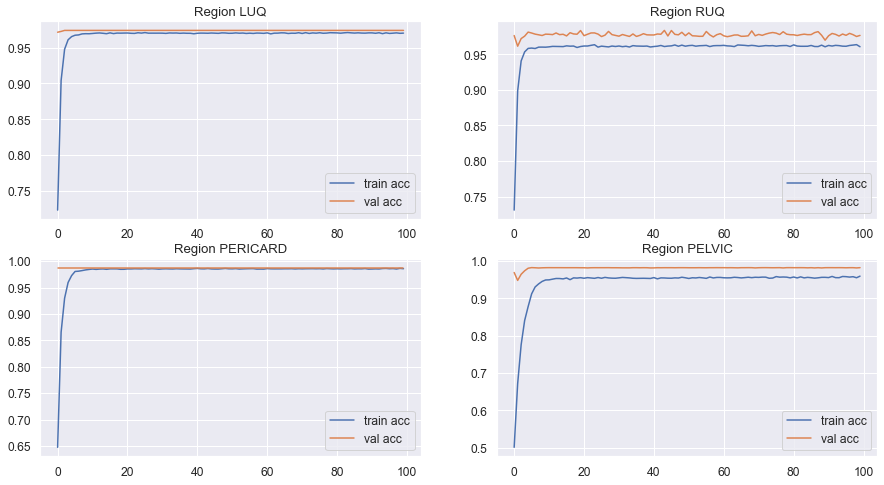

In [508]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    axs[i // 2, i % 2].plot(avg_reg_acc[reg]) 
    axs[i // 2, i % 2].plot(avg_reg_acc_val[reg])
    axs[i // 2, i % 2].set_title(f'Region {reg.name}')
    axs[i // 2, i % 2].legend(['train acc', 'val acc',], loc='best')
    
    
plt.show()
fib.savefig('./reg_avg_train.png', bbox_inches='tight', pad_inches=0)

In [501]:
avg_reg_loss = dict()
avg_reg_loss_val = dict()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    avg = []
    val_avg = []
    for i in range(6):
        avg.append(fine_models_train_hist[i][reg]['loss'])
        val_avg.append(fine_models_train_hist[i][reg]['val_loss'])
    
    avg_reg_loss[reg] = np.mean(avg, axis=0)
    avg_reg_loss_val[reg] = np.mean(val_avg, axis=0)

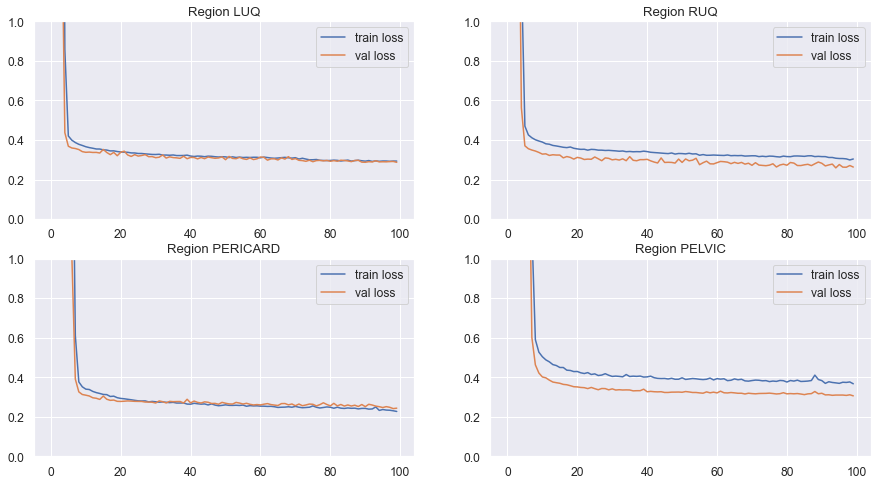

In [506]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    axs[i // 2, i % 2].plot(avg_reg_loss[reg]) 
    axs[i // 2, i % 2].plot(avg_reg_loss_val[reg])
    axs[i // 2, i % 2].set_title(f'Region {reg.name}')
    axs[i // 2, i % 2].set_ylim(0, 1, 0.001)
    axs[i // 2, i % 2].legend(['train loss', 'val loss',], loc='best')
    
    
plt.show()
fib.savefig('./reg_avg_train.png', bbox_inches='tight', pad_inches=0)

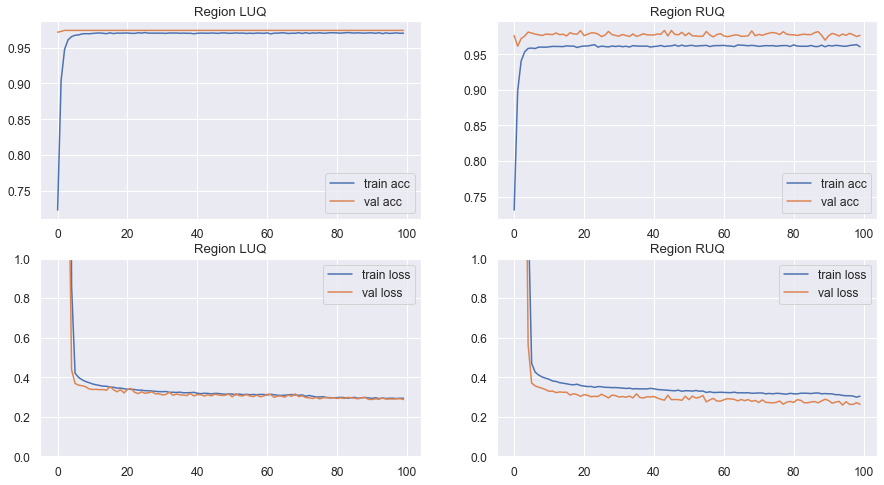

In [554]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ]):
    axs[0, i % 2].plot(avg_reg_acc[reg]) 
    axs[0, i % 2].plot(avg_reg_acc_val[reg])
    axs[0, i % 2].set_title(f'Region {reg.name}')
    axs[0, i % 2].legend(['train acc', 'val acc',], loc='best')

for i, reg in enumerate([Scan.LUQ, Scan.RUQ]):
    axs[1, i % 2].plot(avg_reg_loss[reg]) 
    axs[1, i % 2].plot(avg_reg_loss_val[reg])
    axs[1, i % 2].set_title(f'Region {reg.name}')
    axs[1, i % 2].set_ylim(0, 1, 0.001)
    axs[1, i % 2].legend(['train loss', 'val loss',], loc='best')
    
plt.show()


## Stats

In [73]:
matrices = []
recall_cores = []

model = keras.models.load_model(f'best_model_{1}.tf')
train, valid, test = iterations[1]
train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_test, y_test = test
y_pred = model.predict(x_test)

y_test_cat = keras.utils.to_categorical(y_test)
y_test_cat = y_test_cat.argmax(axis=1)
y_pred = np.argmax(y_pred, axis=1)

recall_cores.append(recall_score(y_test, y_pred, average="macro"))
matrices.append(confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0]))
res_perclass = score(y_test, y_pred,average=None,)

precision, recall, fscore, support = res_perclass
print(f'Model per class {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()

res = score(y_test, y_pred, average='macro')
precision, recall, fscore, support = res
print(f'Model avg {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()
    
    
    

Model per class 2
precision: [0.95145631 0.99539358 0.97979798]
recall: [0.2969697  1.         0.99654592]
fscore: [0.45265589 0.99769147 0.98810099]
support: [  330  7347 11291]

Model avg 2
precision: 0.9755492895278465
recall: 0.7645052061667065
fscore: 0.8128161163656421
support: None



In [612]:
from sklearn.metrics import precision_recall_fscore_support as score

for i in range(6):
    model = keras.models.load_model(f'best_model_{i}.tf')
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_test, y_test = test
    y_pred = model.predict(x_test)
    
    y_test_cat = keras.utils.to_categorical(y_test)
    y_test_cat = y_test_cat.argmax(axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    precision, recall, fscore, support = score(y_test, y_pred)
    
    print(f'Model {i + 1}')
    print('recall: {}'.format(recall))
    print()


/Users/dorn_kern/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 1
recall: [0. 1. 1.]

Model 2
recall: [0. 1. 1.]

Model 3
recall: [0.         1.         0.99970729]

Model 4
recall: [0.         1.         0.95146885]

Model 5
recall: [0.        1.        0.9787295]

Model 6
recall: [0.         0.99908038 0.9784306 ]



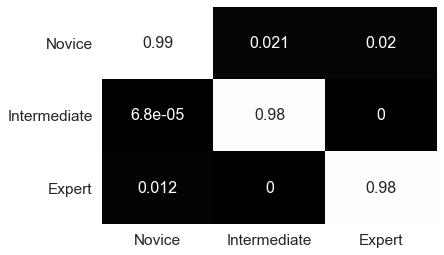

In [45]:
#true (rows), predicted (columns) 
import seaborn as sn
import pandas as pd
labels = ["Novice", "Intermediate", "Expert"]
normalized = summed / np.sum(summed, axis=0)
df_cm = pd.DataFrame(normalized, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray") # font size

plt.show()

In [46]:
recall_cores

[0.8559607869260147,
 0.7645052061667065,
 0.6609185856399599,
 0.6445271908555594,
 0.7323232323232324,
 0.6663202863410692]

In [47]:
recall_cores

[0.8559607869260147,
 0.7645052061667065,
 0.6609185856399599,
 0.6445271908555594,
 0.7323232323232324,
 0.6663202863410692]

In [48]:
np.mean(recall_cores)

0.720759214708757

## stats for regions

In [169]:
from sklearn.metrics import precision_recall_fscore_support as score

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'REGION: {reg}')
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        model = keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf')
        train, valid, test = iterations[i]
        train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_test, y_test = test
        y_pred = model.predict(x_test)

        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        precision, recall, fscore, support = score(y_test, y_pred)

        print(f'Fold {i + 1}')
        print('precision: {}'.format(precision))
        print('recall: {}'.format(recall))
        print('fscore: {}'.format(fscore))
        print('support: {}'.format(support))
    
    print('='*20)


REGION: Scan.LUQ
Fold 1
precision: [0.         1.         0.95472753]
recall: [0. 1. 1.]
fscore: [0.        1.        0.9768395]
support: [  486  9124 10249]
Fold 2
precision: [0.         0.92650028 0.94833922]
recall: [0.        1.        0.9426341]
fscore: [0.         0.96184806 0.94547805]
support: [  717 10097 13963]
Fold 3
precision: [0.         0.96529835 0.95330066]
recall: [0.         1.         0.96799688]
fscore: [0.         0.98234281 0.96059256]
support: [  486  9124 10249]
Fold 4
precision: [0.         0.8091978  0.96663495]
recall: [0.         1.         0.85597933]
fscore: [0.         0.89453768 0.90794805]
support: [  526 10874 17803]
Fold 5
precision: [0.         0.89991087 0.94711219]
recall: [0.         1.         0.91957316]
fscore: [0.         0.94731904 0.93313953]
support: [  717 10097 13963]
Fold 6
precision: [0.         0.89123842 0.96906246]
recall: [0.       1.       0.925462]
fscore: [0.         0.94249187 0.94676052]
support: [  526 10874 17803]
REGION: Sca

## best model test

In [347]:
acc_dict = dict()
recall_dict = dict()
reg_confusions = dict()

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    acc_dict[reg] = []
    recall_dict[reg] = []
    reg_confusions[reg] = []

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'REGION: {reg}')
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        model = keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf')

        x_test, y_test = test
        y_pred = model.predict(x_test)

        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        
        acc_dict[reg].append(model.evaluate(x_test, y_test)[1])
        y_pred = model.predict(x_test)
        
        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        res_perclass = score(y_test, y_pred, average=None,)
        precision, recall, fscore, support = res_perclass

        recall_dict[reg].append(recall)
        reg_confusions[reg].append(confusion_matrix(y_test_cat, y_pred, normalize='true', labels=[2, 1, 0]))

REGION: Scan.LUQ
219/219 [==============================] - 0s 1ms/step - loss: 0.2731 - sparse_categorical_accuracy: 0.9833
REGION: Scan.RUQ
181/181 [==============================] - 0s 1ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.9887
REGION: Scan.PERICARD
140/140 [==============================] - 0s 1ms/step - loss: 0.2383 - sparse_categorical_accuracy: 0.9937
REGION: Scan.PELVIC
120/120 [==============================] - 0s 1ms/step - loss: 0.3545 - sparse_categorical_accuracy: 0.9794


In [320]:
reg_mean= []
for key in acc_dict:
    print(f'{key} Expert | Intermed | Nov')
    
    print(np.mean(np.array(recall_dict[key]), axis=0))


Scan.LUQ Expert | Intermed | Nov
[0. 1. 1.]
Scan.RUQ Expert | Intermed | Nov
[0.         0.99814362 0.98350128]
Scan.PERICARD Expert | Intermed | Nov
[0. 1. 1.]
Scan.PELVIC Expert | Intermed | Nov
[0.         0.99632788 0.99988929]


In [306]:
reg_mean= []
for key in acc_dict:
    reg_mean.append(np.mean(acc_dict[key]))
    print(f'{key} {reg_mean[-1]}')

print(f'All mean {np.mean(reg_mean)}')


Scan.LUQ 0.9739629824956259
Scan.RUQ 0.979611893494924
Scan.PERICARD 0.9877045750617981
Scan.PELVIC 0.981564869483312
All mean 0.9807110801339151


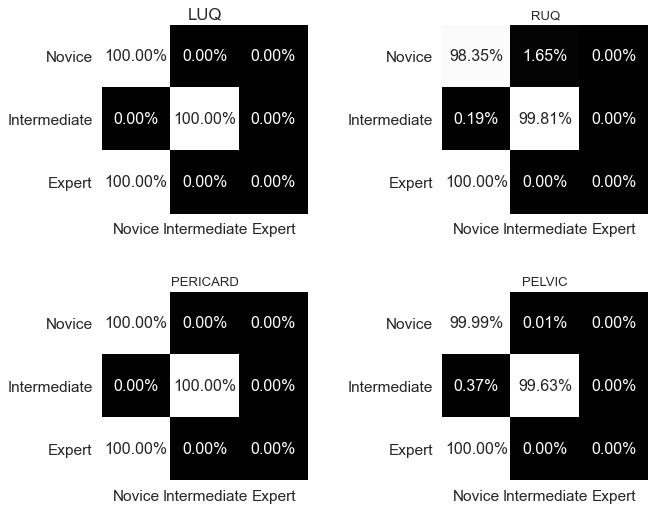

In [400]:
import seaborn as sn
import pandas as pd

fig, axs = plt.subplots(2, 2, figsize=(10,8))
reg_mean_conf= []
for i, key in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    #true (rows), predicted (columns) 
    ax = axs[i // 2, i % 2]
    ax.set_title(key.name)
    labels = ["Novice", "Intermediate", "Expert"]
    normalized = np.mean(reg_confusions[key], axis=(0))
    df_cm = pd.DataFrame(normalized, range(3), range(3))
    sn.set(font_scale=1.1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},  
               yticklabels=labels, 
                xticklabels=labels, 
               cbar=False, cmap='gray',
                ax=ax,  fmt=".2%") # font size
    
fig.tight_layout(pad=3.0)
plt.show()





[[0.99584764 0.00415236 0.        ]
 [0.00138212 0.99861788 0.        ]
 [1.         0.         0.        ]]


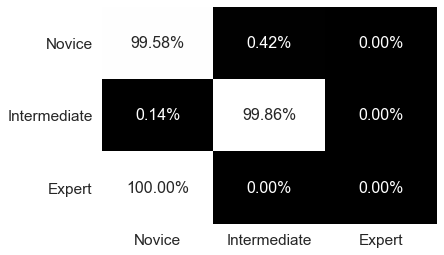

In [399]:
reg_mean_conf= []
for key in reg_confusions:
    reg_mean_conf.append(np.mean(reg_confusions[key], axis=(0)))

all_conf = np.mean(reg_mean_conf, axis=0)
print(all_conf)
df_cm = pd.DataFrame(all_conf, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray",  fmt=".2%") # font size

plt.show()

In [277]:
recall_cores = []
i = 1
reg = Scan.ALL
novices_reg, intermed_reg, experts_reg = prepared[reg]
folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)

train, valid, test = iterations[i]
train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_train, y_train = train
x_val, y_val = valid
x_test, y_test = test

model = keras.models.load_model(f'best_model_{i}.tf')
acc = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
print(f'REg {reg} acc: {acc[1]:.4f}')
y_test_cat = y_test
# y_test_cat = keras.utils.to_categorical(y_test)
# y_test_cat = np.argmax(y_test_cat, axis=1)
y_pred = np.argmax(y_pred, axis=1)

recall_cores.append(recall_score(y_test, y_pred, average="macro"))
all_confusion_matrix = confusion_matrix(y_test_cat, y_pred,labels=[2, 1, 0])
print(all_confusion_matrix)
res_perclass = score(y_test, y_pred,average=None,)

precision, recall, fscore, support = res_perclass
print(f'Model per class {2} Region: {reg}')
print(f'recall: {recall}')
print(f'recall: {support}')
plt.show()

775/775 [==============================] - 1s 1ms/step - loss: 0.2838 - sparse_categorical_accuracy: 0.9711
REg Scan.ALL acc: 0.9711
[[13963     0     0]
 [    0 10097     0]
 [  717     0     0]]
Model per class 2 Region: Scan.ALL
recall: [0. 1. 1.]
recall: [  717 10097 13963]


In [ ]:
#true (rows), predicted (columns) 
import seaborn as sn
import pandas as pd
labels = ["Novice", "Intermediate", "Expert"]
normalized = summed / np.sum(summed, axis=0)
df_cm = pd.DataFrame(normalized, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray") # font size

plt.show()

In [401]:
[ProficiencyLabel.Novice]*5

[<ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>]

## voting for model 2


In [467]:
i = 1
reg = Scan.ALL
model = keras.models.load_model(f'best_model_{i}.tf')

novices_reg, intermed_reg, experts_reg = prepared[reg]
folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)

train, valid, test = iterations[i]
train, valid, test_reg = folds_reg[train], folds_reg[valid], folds_reg[test]
test_nov = test_reg[0]

test_classes = [ProficiencyLabel.Novice]*5 #+ [ProficiencyLabel.Intermediate]*4 + [ProficiencyLabel.Expert]
for i, true_label in zip(range(5), test_classes):
    test_sliced_x, test_sliced_y = ut.data_slicing(np.array([test_nov[i]]), slice_window, true_label)
    y_pred = model.predict(np.array(test_sliced_x))
    y_pred = np.argmax(y_pred, axis=1)
    counts = np.bincount(y_pred)
    print(f'Class {ProficiencyLabel(np.argmax(counts)).name}, true class: {true_label}')

test_inter = test_reg[1]
test_classes = [ProficiencyLabel.Intermediate]*5 #+ [ProficiencyLabel.Expert]
for i, true_label in zip(range(5), test_classes):
    test_sliced_x, test_sliced_y = ut.data_slicing(np.array([test_inter[i]]), slice_window, true_label)
    y_pred = model.predict(np.array(test_sliced_x))
    y_pred = np.argmax(y_pred, axis=1)
    counts = np.bincount(y_pred)
    print(f'Class {ProficiencyLabel(np.argmax(counts)).name}, true class: {true_label}')
    
test_exp = test_reg[2]
test_classes = [ProficiencyLabel.Expert]
for i, true_label in zip(range(1), test_classes):
    test_sliced_x, test_sliced_y = ut.data_slicing(np.array([test_exp[i]]), slice_window, true_label)
    y_pred = model.predict(np.array(test_sliced_x))
    y_pred = np.argmax(y_pred, axis=1)
    counts = np.bincount(y_pred)
    print(f'Class {ProficiencyLabel(np.argmax(counts)).name}, true class: {true_label}')

Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Novice, true class: ProficiencyLabel.Expert


In [470]:
iterations

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [602]:
def consensus(reg, fold_pair, true_label, part):
    models = []
    votes = []
    for i in fold_pair:
        models.append(keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf'))
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    
    train, valid, test = iterations[fold_pair[0]]
    train, valid, test_reg = folds_reg[train], folds_reg[valid], folds_reg[test]
    samples = test_reg[part]
    
    test_classes = [true_label]*len(samples)
    for i, true_label in zip(range(len(samples)), test_classes):
        test_sliced_x, test_sliced_y = ut.data_slicing(np.array([samples[i]]), slice_window, true_label)
        
        for m in models:
            y_pred = m.predict(np.array(test_sliced_x))
            y_pred = np.argmax(y_pred, axis=1)
            counts = np.bincount(y_pred)

            model_vote = ProficiencyLabel(np.argmax(counts))
            print(f'Class {model_vote.name}, true class: {true_label}')
            votes.append((model_vote, true_label))
    
    return votes

In [603]:
def count_consensus(votes, true_label):
    stats = dict()
    
    for l in [ProficiencyLabel.Novice, ProficiencyLabel.Intermediate, ProficiencyLabel.Expert]:
        stats[l] = 0
    
    for v in votes:
        stats[v[0]] += 1
    
    
    print(f'True label: {true_label}')
    for k in stats:
        print(f'{k}: {stats[k]}')

In [611]:
conf_stats = dict()


fold_pairs = [(0, 2), (1, 4), (3, 5)]
true_lab = ProficiencyLabel.Intermediate
part = np.abs(true_lab.value - 2) # 0 - N, 1 - I, 2 - E
for reg in [Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]:
    print(f'{true_lab} for {reg}')
    f1 = consensus(reg, fold_pairs[0], true_lab, part)
    print()
    f2 = consensus(reg, fold_pairs[1], true_lab, part)
    print()
    f3 = consensus(reg, fold_pairs[2], true_lab, part)
    print()
    count_consensus(f1+f2+f3, true_lab)
    print()
    print()


ProficiencyLabel.Intermediate for Scan.LUQ
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate

Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true c